In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.functional as Faudio
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torchaudio
import sys
import torchaudio.transforms as T
import os
!pip install torchsummary
from torchsummary import summary


import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
class SubsetAudio(Dataset):
    def __init__(self, root_dir, subset, transform = None):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        self.file_list = self.load_file_list()
        self.sample_rate = 16000

    def load_file_list(self):
        file_list = []
        for folder_name in self.subset:
            folder_path = os.path.join(self.root_dir, folder_name)
            files = os.listdir(folder_path)
            files = [os.path.join(folder_path, file) for file in files]
            file_list.extend(files)
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_path = self.file_list[index]
        waveform, sample_rate = torchaudio.load(file_path)
        waveform = self.resample(waveform, sample_rate)
        label = self.get_label(file_path)
        waveform = self.mix_down(waveform)
        waveform = waveform[:, :48000]
        waveform = self.padding(waveform)
        if self.transform is not None:
            waveform = self.transform(waveform)
        label = torch.Tensor([1]) if label == 'Parsed_Capuchinbird_Clips' else torch.Tensor([0])
        return waveform, label

    def get_label(self, file_path):
        # Extract label from the file path
        label = os.path.basename(os.path.dirname(file_path))
        return label
    
    def resample(self,signal, sr):
        if sr != self.sample_rate:
            signal = Faudio.resample(signal, sr, self.sample_rate)
        return signal
    
    def padding(self, waveform):
        length = waveform.shape[1]
        if length<48000:
            num_padding = 48000 - length
            waveform = torch.nn.functional.pad(waveform, (0,num_padding))
        return waveform
    
    def mix_down(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    


# Specify the root directory and subsets
root_dir = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing"
training_subset = ["Parsed_Capuchinbird_Clips", "Parsed_Not_Capuchinbird_Clips"]
testing_subset = ["Forest Recordings"]

#Transform the audio
transform = T.MelSpectrogram(sample_rate=16000)

sample_rate = 16000

# Create training and testing sets
train_set = SubsetAudio(root_dir, training_subset, transform)
test_set = SubsetAudio(root_dir, testing_subset, transform)

# Accessing the first element of the training set
waveform, label = train_set[500]


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [27]:
labels = sorted(list(set(datapoint[1] for datapoint in train_set)))
len(labels)

810

In [5]:
waveform,  label = train_set[1]

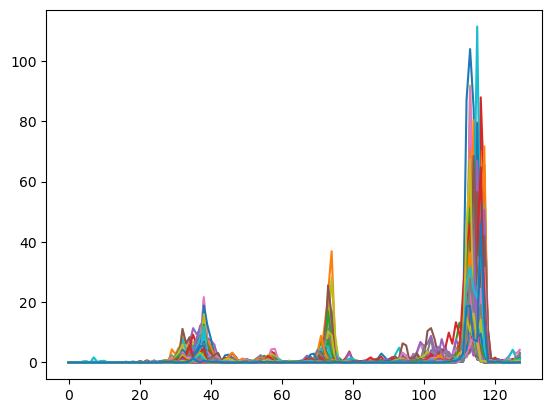

In [6]:
plt.plot(waveform.squeeze())
plt.show()

In [8]:
waveform.shape

torch.Size([1, 128, 241])

In [15]:
class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=2,bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=2,bias=False),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=2,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

        
        self.flatten = nn.Flatten()
        self.linear1 = nn.Sequential(
                        nn.Linear(33728, 128),
                        nn.ReLU()) 
        self.linear2 = nn.Sequential(
                        nn.Linear(128, 16),
                        nn.ReLU()) 
        self.linear3 = nn.Sequential(
                        nn.Linear(16, 1),
                        nn.Sigmoid()) 

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)

        

        return x

In [16]:
model = CNNNetwork()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using ", device)
model = model.to(device)
print(summary(model,(1,128,241)))

using  cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 130, 243]             144
       BatchNorm2d-2         [-1, 16, 130, 243]              32
              ReLU-3         [-1, 16, 130, 243]               0
         MaxPool2d-4          [-1, 16, 65, 121]               0
            Conv2d-5          [-1, 32, 67, 123]           4,608
       BatchNorm2d-6          [-1, 32, 67, 123]              64
              ReLU-7          [-1, 32, 67, 123]               0
         MaxPool2d-8           [-1, 32, 33, 61]               0
            Conv2d-9           [-1, 64, 35, 63]          18,432
      BatchNorm2d-10           [-1, 64, 35, 63]             128
             ReLU-11           [-1, 64, 35, 63]               0
        MaxPool2d-12           [-1, 64, 17, 31]               0
          Flatten-13                [-1, 33728]               0
           Linear-14        

In [20]:
batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [21]:

# Create training data loader
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10
criterion = nn.BCELoss()


In [23]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model in training mode

    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, (waveforms,  labels) in enumerate(train_loader):
        waveforms = waveforms.to(device)
#         sample_rates = sample_rates.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(waveforms)

        # Calculate loss
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        predicted_labels = (outputs >= 0.5).float()  # Convert probabilities to binary predictions
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

        if (batch_idx + 1) % 10 == 0:
            print(f"Batch {batch_idx+1}/{len(train_loader)} | Loss: {loss.item()}")

    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    print(f"Train Loss: {average_loss} | Train Accuracy: {accuracy}")

    return average_loss, accuracy

In [24]:
num_epochs = 60

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)

Epoch 1/60
Train Loss: 1.876712128520012 | Train Accuracy: 0.6259259259259259
Epoch 2/60
Train Loss: 1.038567516952753 | Train Accuracy: 0.8135802469135802
Epoch 3/60
Train Loss: 1.0594466105103493 | Train Accuracy: 0.8691358024691358
Epoch 4/60
Train Loss: 0.39676450565457344 | Train Accuracy: 0.9407407407407408
Epoch 5/60
Train Loss: 0.14150791428983212 | Train Accuracy: 0.9493827160493827
Epoch 6/60
Train Loss: 0.11366358771920204 | Train Accuracy: 0.9555555555555556
Epoch 7/60
Train Loss: 0.08392062783241272 | Train Accuracy: 0.9679012345679012
Epoch 8/60
Train Loss: 0.059430905152112246 | Train Accuracy: 0.9691358024691358
Epoch 9/60
Train Loss: 0.04923990787938237 | Train Accuracy: 0.971604938271605
Epoch 10/60
Train Loss: 0.04605158884078264 | Train Accuracy: 0.980246913580247
Epoch 11/60
Train Loss: 0.07143090292811394 | Train Accuracy: 0.9740740740740741
Epoch 12/60
Train Loss: 0.0546862012706697 | Train Accuracy: 0.9765432098765432
Epoch 13/60
Train Loss: 0.05124655831605196 

In [25]:
torch.save(model.state_dict(), "trained_model_60_epochs.pth")

In [11]:
class testing():
    def __init__(self, transform = None):
        self.transform = transform
        self.sample_rate = 16000


    def get_slices_from_audio_file(self, file_path):
        waveform, sample_rate = torchaudio.load(file_path)
        waveform = self.resample(waveform, sample_rate)
        waveform = self.mix_down(waveform)
        
        desired_duration = 3  # or any desired duration in seconds
        desired_length = int(desired_duration * self.sample_rate)
        num_slices = waveform.size(1) // desired_length

        slices = []
        for i in range(num_slices):
            start = i * desired_length
            end = (i + 1) * desired_length
            slice_waveform = waveform[:, start:end]
            # Apply padding if necessary
            slice_waveform = self.padding(slice_waveform)
            if self.transform is not None:
                slice_waveform = self.transform(slice_waveform)
            slices.append(slice_waveform)
        return slices

    
    def resample(self,signal, sr):
        if sr != self.sample_rate:
            signal = Faudio.resample(signal, sr, self.sample_rate)
        return signal
    
    def padding(self, waveform):
        length = waveform.shape[1]
        if length<48000:
            num_padding = 48000 - length
            waveform = torch.nn.functional.pad(waveform, (0,num_padding))
        return waveform
    
    def mix_down(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    
testing_subset = ["Forest Recordings"]

#Transform the audio
transform = T.MelSpectrogram(sample_rate=16000)

sample_rate = 16000

# Create testing sets
test_set = testing(transform)

# Accessing the first element of the test set


In [17]:
import pandas as pd

test_folder = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings"
file_list = os.listdir(test_folder)

csv_file = 'predictions.csv'  

test = testing(transform)

data = []

for filename in file_list:
    file_path = os.path.join(test_folder, filename)
    slices = test.get_slices_from_audio_file(file_path)  
    
    for s in slices:
        s = s.to(device)
        s = s.unsqueeze(dim=0)
        output = model(s).item()  
        
        data.append({'Audio File': filename, 'Prediction': output})

df = pd.DataFrame(data)

# Append data to CSV file
df.to_csv(csv_file, mode='a', index=False, header=not os.path.exists(csv_file))
